# **CHEM E 545 Midterm Exam** 
Please put team name in the submisson (.ipynb file). Run your notebook so that your outputs are visible and comment throughout your code. **(80 points)**

In this project, you will develop a supervised machine learning model to predict the Gibbs free energy of solvation (ΔG).  ΔG is a crucial property for modeling various chemical processes, including electrochemistry and drug delivery systems.  While traditional methods like quantum mechanics and molecular dynamics have been used extensively for predicting ΔG, machine learning has recently emerged as a popular alternative.  By establishing relationships between molecular structure and activity, machine learning models can effectively predict thermodynamic properties.  Your focus will be on building generalizable machine learning models for ΔG prediction.  Furthermore, you will perform feature selection to identify the most influential molecular descriptors.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

## **Question 1** 
Begin by loading the data and separating it into features (X) and target variable (y).  Handle any missing values by replacing them with zero.  Next, preprocess the data in preparation for machine learning.  Briefly explain the chosen preprocessing method and the rationale behind its selection.  Use a random state of 42 for any processes requiring randomization. **(10 points)**

In [2]:
# Load the dataset
df = pd.read_csv('Gibbs_predictor_545_data_final_2.csv')

In [3]:
# Separate the features and the target variable and keep only numerical features
X = df.drop(columns=['gibbs_free_energy', 'Solvent_Type'])
y = df['gibbs_free_energy']

# Handle missing values by replacing them with zeros
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

## **Question 2**
Based on the problem statement and the nature of the output you are predicting with your machine learning model, justify whether regression or classification is the more appropriate choice. Implement the chosen approach using linear models, Support Vector Machines (SVMs), and Random Forests (RFs). **(20 points)**

Adhere to the following specifications for model development:

Regression is best to use in this case since the data is continuous as opposed to discreet

### **(a) Data Splitting**
Initially, divide your data into training and testing sets using an 80/20 split. Subsequently, split the testing set into validation and final test sets, each comprising 50% of the original testing data.

In [4]:
# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the test set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### **(b) Model Parameters**
For the SVM model, utilize the radial basis function (rbf) kernel with a regularization parameter (C) of 10. For the RF model, configure the following hyperparameters: 250 trees, a minimum of 2 samples required to split an internal node, a minimum of 1 sample required to be at a leaf node, the square root of the total number of features as the maximum number of features considered for splitting a node, and disable bootstrapping.

In [5]:
# Define the models individually
linear = LinearRegression()  # Linear regression
svm = SVR(C=10, kernel='rbf')  # Support Vector Regression
rf = RandomForestRegressor(
    n_estimators=250, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_features='sqrt', 
    bootstrap=False,
    random_state=42
)  # Random Forest

# Dictionary to map models to their names
model_names = {
    linear: 'Linear Regression', 
    svm: 'Support Vector Regression', 
    rf: 'Random Forest'
}

In [6]:
# Function to fit the model (No prediction yet)
def Q2(model):
    """Fits the model to the training data."""
    model.fit(X_train_scaled, y_train)
    return model

## **Question 3** 
Model Evaluation. Your code should output a .csv file that has the following columns:

```algorithm```

```test_score```

```mean absolute error```

 ```standard deviaiton of mean absolute errors```
(calculated using 10-fold cross on the validation dataset.)


You will have the three performance metrics for each of your three algorithms in your ```output.csv``` file. Also plot these three metrics for your algorithms in one bar plot. **(20 points)**

In [7]:
import csv
import os

def save_results_to_csv(results, filename="output.csv"):
    """Saves the results to a CSV file."""
    
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as f:
        writer = csv.writer(f)
        
        # Write header if file does not exist
        if not file_exists:
            writer.writerow(["algorithm", "test_score", "mean absolute error", "standard deviation of mean absolute errors"])
        
        # Write results
        writer.writerow(results)

In [ ]:
def Q3(model):
    """Evaluate the model, save results to a CSV file, and print the results."""
    
    # Get the model name
    model_name = model_names[model]

    # Fit the model
    Q2(model)

    # Calculate test score and mean absolute error
    test_score = model.score(X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)

    # Perform 10-fold cross validation
    mae_val = -cross_val_score(model, X_val_scaled, y_val, scoring='neg_mean_absolute_error', cv=10)
    std_mae_val = mae_val.std()

    # Print the results
    print(f'Model: {model_name}')
    print('Test Score:', test_score)
    print('MAE:', mae)
    print('10-Fold Cross-Validation on Validation Set:')
    print('Standard deviation of MAE:', std_mae_val)
    print('-' * 50)
    # Save the output to a csv file
    save_results_to_csv([model_name, test_score, mae, std_mae_val])
    print('Results saved to output.csv\n')
    
Q3(linear)
Q3(svm)
Q3(rf)

Model: Linear Regression
Test Score: 0.820882389889349
MAE: 0.62786563534451
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 17279829.54486332
--------------------------------------------------
Model: Support Vector Regression
Test Score: 0.9092623091458731
MAE: 0.22063670707492294
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.15032819357164842
--------------------------------------------------
Model: Random Forest
Test Score: 0.9596885553053893
MAE: 0.2129336328438464
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.1298360058578479
--------------------------------------------------


## **Question 4** 
Calculate the feature importance for all three models. Note that for non-linear models, simply using coefficients does not provide an accurate estimate of feature importance.  Permutation feature importance is generally recommended in such cases. For consistency, use permutation feature importance for all three models.

### **(1)**
Remove any **negative and zero** importance features and see what happens to MAE and the standard deviation of MAE in the cross_val scores. **(10 points)**

In [20]:
def Q4_1(model):
    """Remove features with negative and zero importance and evaluate the model."""
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Perform permutation importance
    perm_importance = permutation_importance(model, X_val_scaled, y_val, n_repeats=3, random_state=42)

    # Get the mean feature importance
    importances = perm_importance.importances_mean
    indices = np.argsort(importances)[::-1]

    # Keep only indices where importance is greater than 0
    selected_indices = indices[importances[indices] > 0]

    # Filter dataset with selected features
    X_train_perm = X_train_scaled[:, selected_indices]
    X_val_perm = X_val_scaled[:, selected_indices]
    X_test_perm = X_test_scaled[:, selected_indices]

    # Fit the model with the reduced features
    model.fit(X_train_perm, y_train)

    # Perform 10-fold cross validation
    mae_val = -cross_val_score(model, X_val_perm, y_val, scoring='neg_mean_absolute_error', cv=10)
    std_mae_val = mae_val.std()

    # Calculate test score and mean absolute error
    test_score = model.score(X_test_perm, y_test)
    y_pred = model.predict(X_test_perm)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Return y_pred for Q5
    model_name = model_names[model].replace(" ", "_")  # Ensure name is formatted for use
    return {f"y_pred_{model_name}": y_pred}    
    
    # Print the results
    print(f'Model: {model_names[model]} (Permutation Importance)')
    print('Test Score:', test_score)
    print('MAE:', mae)
    print('10-Fold Cross-Validation on Validation Set:')
    print('Standard deviation of MAE:', std_mae_val)
    print('-' * 50)

In [21]:
Q4_1(linear)

{'y_pred_Linear_Regression': array([ -4.13677112,  -5.04962082,  -5.26730767,   0.70904032,
         -6.20699125,  -4.12967411,  -4.06584853,  -3.46170735,
         -4.23531716,  -7.37745176,  -5.94770163,  -4.47707083,
         -2.83700958,  -6.24238157,  -3.17704704,  -3.85338372,
         -4.86876178,  -3.45794268,  -4.05031096,  -2.61469356,
         -3.04082063,  -5.07985298,  -1.98569299,  -4.20577583,
         -3.87251815,  -5.16782429,  -4.55644325,  -4.12468258,
         -9.91188598,  -4.07502844,  -3.5753274 ,  -4.8228087 ,
         -4.11567746,  -2.01742591,  -5.31441135,  -4.27642149,
         -4.20380343,  -5.20961756,  -7.65698869,  -3.68742945,
         -3.79322144,  -1.94458555,  -5.14964246,  -3.63819742,
         -4.57730784,  -0.23934486,  -1.40222828,  -5.94383692,
         -8.07801097,   0.11518026,   0.15119807,  -9.57903747,
         -3.64824898,  -5.85119905,  -3.95055437,  -7.51760775,
         -9.46651859,  -3.88133987,  -4.37953481,  -4.17473589,
         -5.

In [15]:
Q4_1(svm)

KeyboardInterrupt: 

In [16]:
Q4_1(rf)

Model: Random Forest (Permutation Importance)
Test Score: 0.9594430858854487
MAE: 0.21159448345391033
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.1282197777558888
--------------------------------------------------


### **(2)**
Make a bar plot of the top 10 features. Use only the top features and see what happens to MAE and the standard deviation of MAE in the cross_val scores.**(10 points)**

In [17]:
def Q4_2(model):
    """Keep only top 10 importances, evaluate the model, and plot the feature importances."""
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Perform permutation importance
    perm_importance = permutation_importance(model, X_val_scaled, y_val, n_repeats=30, random_state=42)

    # Get the mean feature importance
    importances = perm_importance.importances_mean
    indices = np.argsort(importances)[::-1]

    # Keep the top 10 features
    X_train_perm = X_train_scaled[:, indices[:10]]
    X_val_perm = X_val_scaled[:, indices[:10]]
    X_test_perm = X_test_scaled[:, indices[:10]]

    # Fit the model with the reduced features
    model.fit(X_train_perm, y_train)

    # Perform 10-fold cross validation
    mae_val = -cross_val_score(model, X_val_perm, y_val, scoring='neg_mean_absolute_error', cv=10)
    std_mae_val = mae_val.std()

    # Calculate test score and mean absolute error
    test_score = model.score(X_test_perm, y_test)
    y_pred = model.predict(X_test_perm)
    mae = mean_absolute_error(y_test, y_pred)

    # Plot a vertical bar chart of the feature importances with X-axis as importance and Y-axis as feature names
    plt.figure(figsize=(10, 6))
    plt.barh(range(10), importances[indices[:10]])
    plt.yticks(range(10), X.columns[indices[:10]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'{model_names[model]} (Permutation Importance)')
    plt.gca().invert_yaxis()
    plt.show()


    # Print the results
    print(f'Model: {model_names[model]} (Permutation Importance)')
    print('Test Score:', test_score)
    print('MAE:', mae)
    print('10-Fold Cross-Validation on Validation Set:')
    print('Standard deviation of MAE:', std_mae_val)
    print('-' * 50)

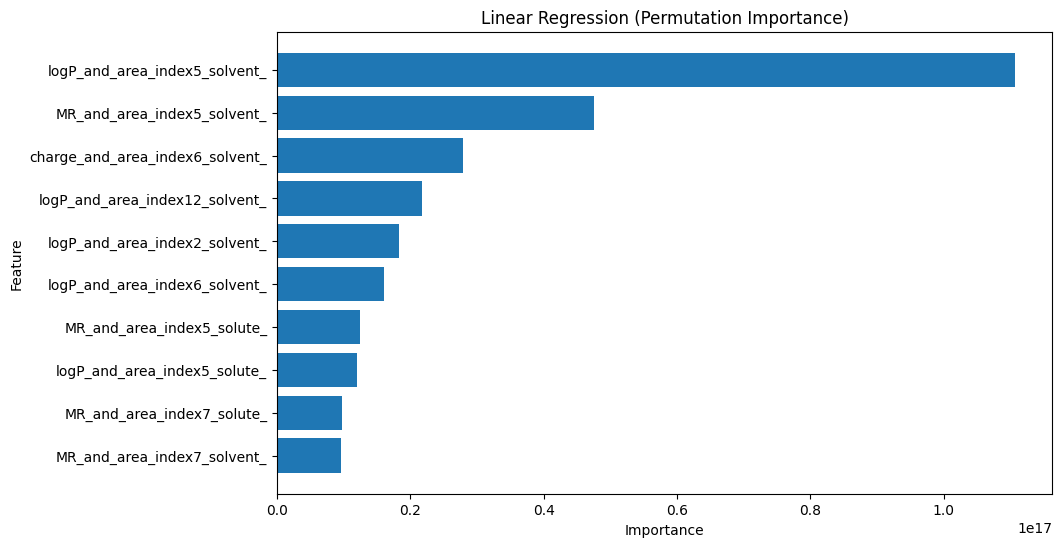

Model: Linear Regression (Permutation Importance)
Test Score: 0.14586859188224965
MAE: 1.4282778203010196
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.21819260852089692
--------------------------------------------------


In [18]:
Q4_2(linear)

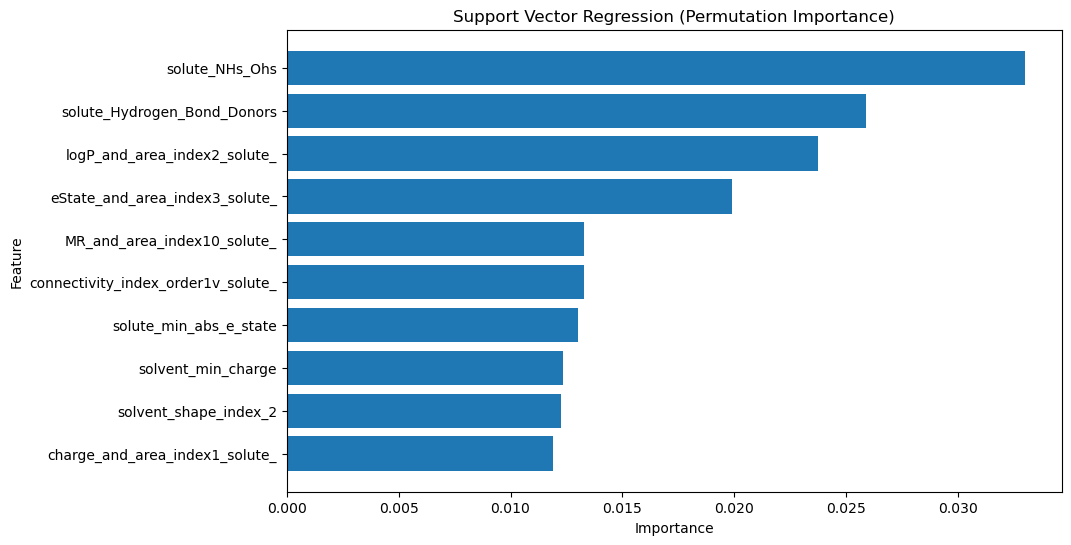

Model: Support Vector Regression (Permutation Importance)
Test Score: 0.7276528744330681
MAE: 0.6329822483786495
10-Fold Cross-Validation on Validation Set:
Standard deviation of MAE: 0.18161655014104497
--------------------------------------------------


In [ ]:
Q4_2(svm)

In [ ]:
Q4_2(rf)

## **Question 5**
Visualize the performance of your model in 4.1 on the entire dataset by plotting the predicted ΔG on the y-axis and the experimental ΔG on the x-axis. Color the data points based on the solvent group type. **(5 points)**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_Q4_1_results(model):
    """Plots predicted Gibbs free energy vs actual values with color coding for solvent type."""
    
    # Get the model name
    model_name = model_names[model].replace(" ", "_")

    # Run Q4_1 and get predictions
    y_pred_dict = Q4_1(model)
    y_pred = y_pred_dict[f"y_pred_{model_name}"]

    # Get solvent types and assign unique colors
    solvent_types = df.loc[y_test.index, "Solvent_Type"]
    unique_solvents = solvent_types.unique()
    color_map = {solvent: i for i, solvent in enumerate(unique_solvents)}

    # Convert solvent types to numerical color labels
    colors = solvent_types.map(color_map)

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(y_test, y_pred, c=colors, cmap='viridis', alpha=0.7)

    # Plot y = x line for reference
    plt.plot(y_test, y_test, color='red', linestyle='--')

    # Labels and title
    plt.xlabel("Experimental ΔG")
    plt.ylabel("Predicted ΔG")
    plt.title(f"Predicted vs. Actual Gibbs Free Energy ({model_names[model]})")

    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(unique_solvents)), markersize=8)
               for i, solvent in enumerate(unique_solvents)]
    plt.legend(handles, unique_solvents, title="Solvent Type", loc="upper left", bbox_to_anchor=(1, 1))

    plt.show()


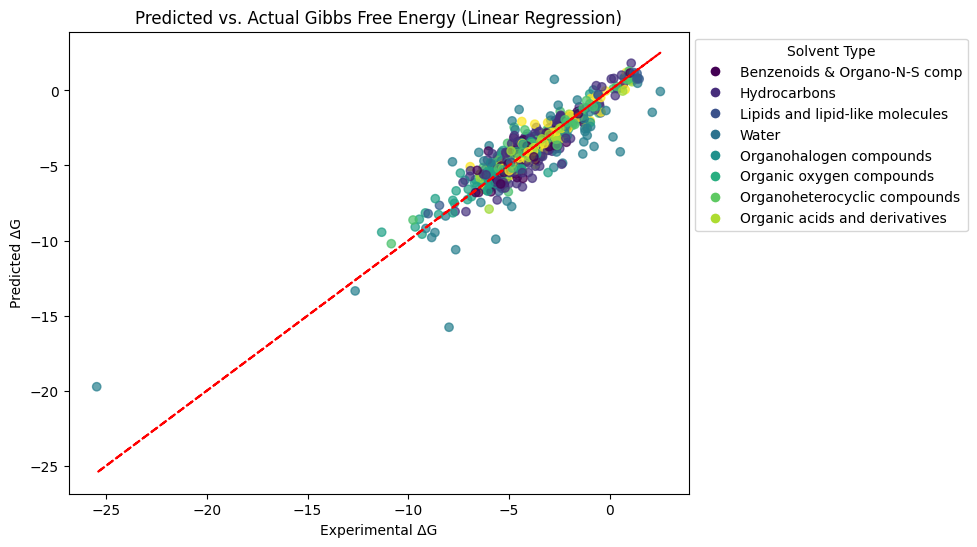

In [25]:
plot_Q4_1_results(linear)

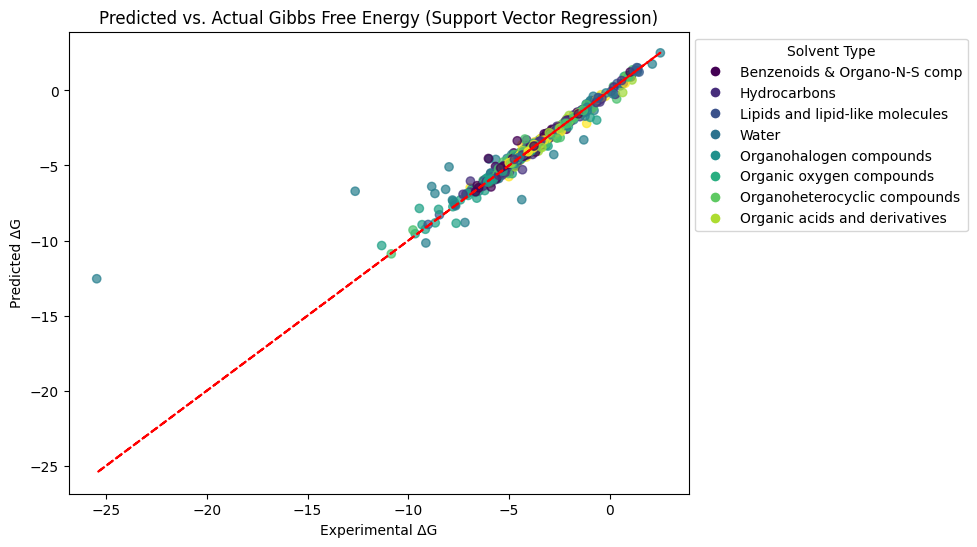

In [29]:
plot_Q4_1_results(svm)

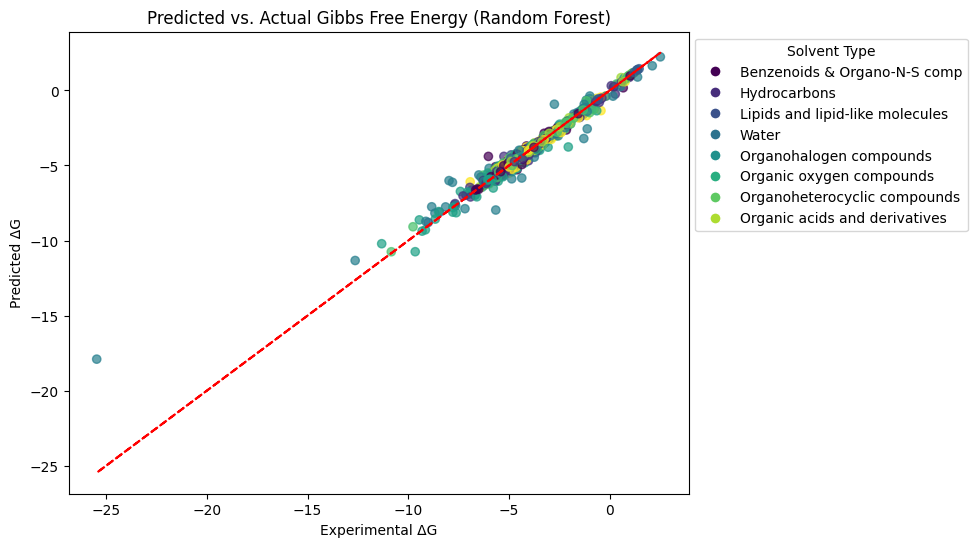

In [28]:
plot_Q4_1_results(rf)

## **Question 6**
Summarize your work and discuss what you learnt. **(5 points)**